<!-- # Ross Sea synthetic gravity inversion -->

<!-- import packages -->

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import shutil
import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions, profiles
from polartoolkit import utils as polar_utils
import string
import copy
from tqdm.autonotebook import tqdm
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import RIS_gravity_inversion.plotting as RIS_plotting
import pygmt
import scipy as sp
import itertools
import matplotlib.pyplot as plt
os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

<!-- # Get synthetic model data -->

INFO:root:using preprocessed 5km grid since spacing is > 5km
INFO:root:returning grid with new region and/or registration, same spacing
INFO:root:returning grid with new region and/or registration, same spacing


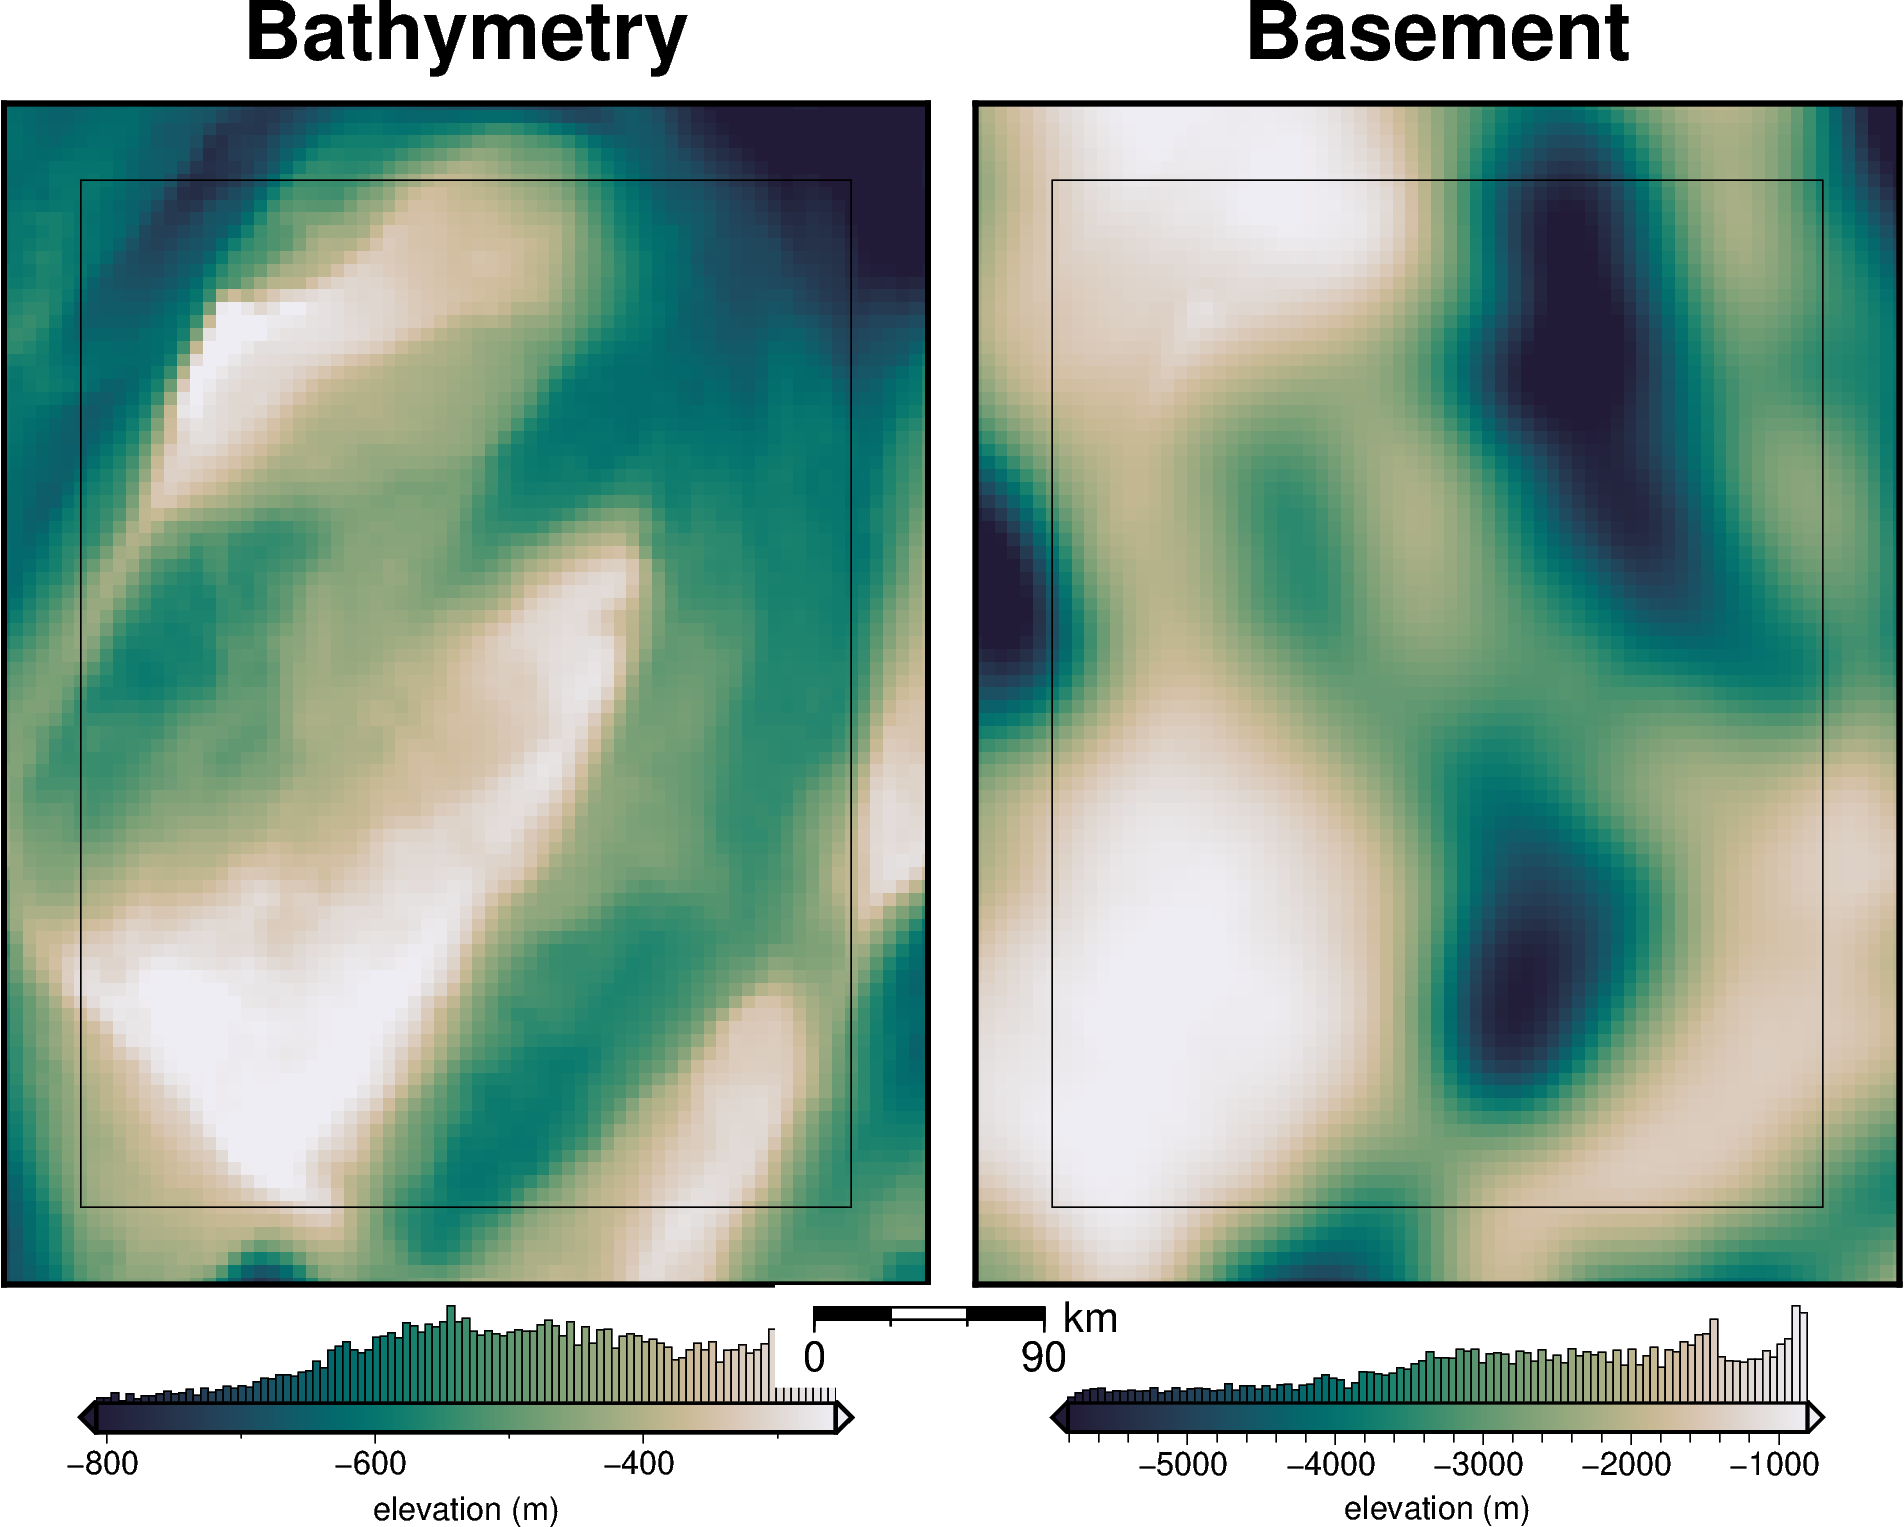

  0%|          | 0/4941 [00:00<?, ?it/s]

  0%|          | 0/4941 [00:00<?, ?it/s]

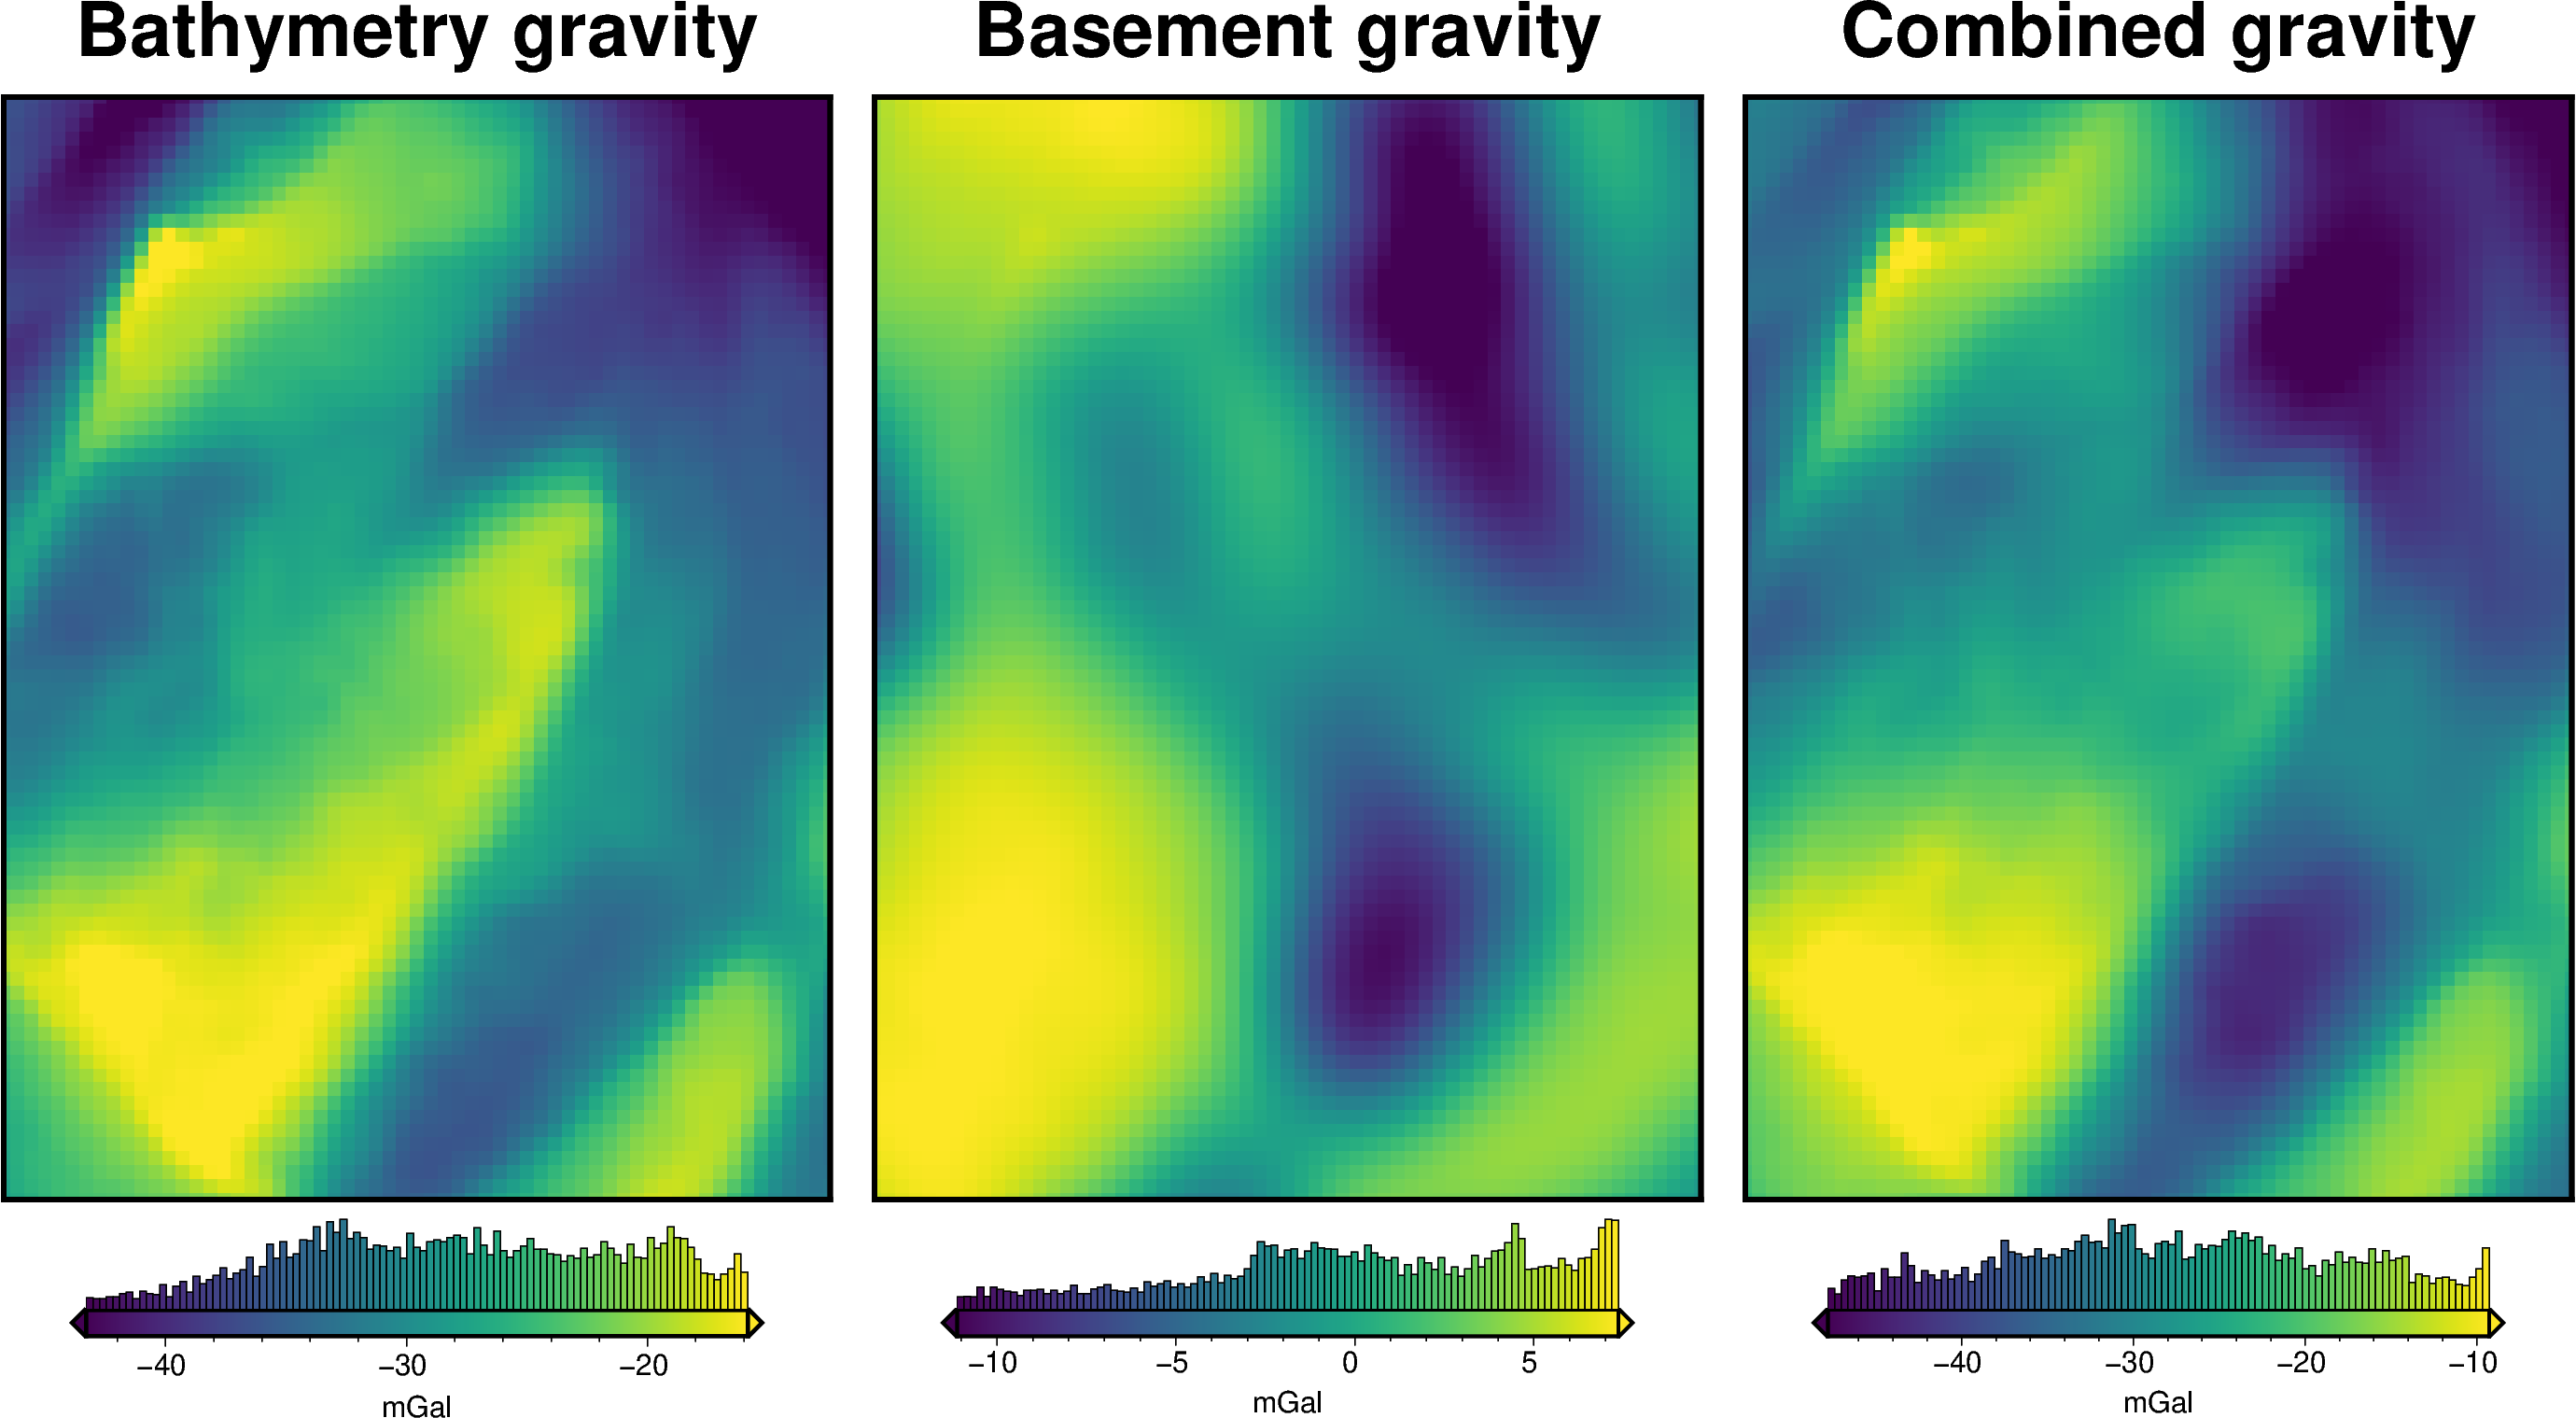

In [2]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

true_density_contrast = 1476

bathymetry, basement, original_grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing*6,
    basement=True,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [3]:
# antgg = fetch.gravity(
#     region=inversion_region,
#     version="antgg-update",
#     anomaly_type="DG",
# )
# maps.plot_grd(
#     antgg,
#     cmap="viridis",
#     region=inversion_region,
#     hist=True,
#     title="AntGG gravity",
#     robust=True,
# )
# antgg -= antgg.mean()
# utils.rmse(antgg)

In [4]:
# normalize regional gravity between -1 and 1
original_grav_df["basement_grav_normalized"] = vd.grid_to_table(utils.normalize_xarray(
    original_grav_df.set_index(["northing", "easting"]).to_xarray().basement_grav,
    low=-1,
    high=1,
)).reset_index().basement_grav
original_grav_df = original_grav_df.drop(columns=["basement_grav", "disturbance", "gravity_anomaly"])
original_grav_df

,northing,easting,upward,bathymetry_grav,basement_grav_normalized
0,-1800000.0,-40000.0,1000.0,-28.046289,0.830177
1,-1800000.0,-35000.0,1000.0,-26.714502,0.867672
2,-1800000.0,-30000.0,1000.0,-25.919276,0.898289
3,-1800000.0,-25000.0,1000.0,-25.236960,0.921973
4,-1800000.0,-20000.0,1000.0,-24.610928,0.937189
...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,0.243973
4937,-1400000.0,245000.0,1000.0,-48.356131,0.167427
4938,-1400000.0,250000.0,1000.0,-49.079005,0.076264
4939,-1400000.0,255000.0,1000.0,-49.877171,-0.022265


In [5]:
# re-scale the regional gravity
regional_grav = utils.normalize_xarray(
    original_grav_df.set_index(['northing', 'easting']).to_xarray().basement_grav_normalized,
    low=0,
    high=50,
).rename("basement_grav")
regional_grav -= regional_grav.mean()

# add to dataframe
original_grav_df["basement_grav"] = vd.grid_to_table(regional_grav).reset_index().basement_grav

# add basement and bathymetry forward gravities together to make observed gravity
original_grav_df["gravity_anomaly_full_res_no_noise"] = original_grav_df.bathymetry_grav + original_grav_df.basement_grav

new_reg = original_grav_df.set_index(['northing', 'easting']).to_xarray().basement_grav
new_reg -= new_reg.mean()
utils.rmse(new_reg)

np.float64(12.29527634158307)

<!-- # Set filename -->

In [6]:
ensemble_path = f"../../results/10_grav_spacing_vs_noise_ensemble_strong_regional"
ensemble_fname = f"{ensemble_path}.csv"

<!-- # Make starting bathymetry model -->

In [7]:
# semi-regularly spaced
constraint_points = RIS_synth.constraint_layout_number(
    shape=(4,5),
    region=inversion_region,
    padding=-spacing,
)

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "true_upward",
    coord_names=("easting", "northing"),
)
constraint_points["upward"] = constraint_points.true_upward
constraint_points.head()

,northing,easting,true_upward,upward
0,-1756000.0,1250.0,-277.117397,-277.117397
1,-1756000.0,73750.0,-292.754172,-292.754172
2,-1756000.0,146250.0,-587.490438,-587.490438
3,-1756000.0,218750.0,-303.910608,-303.910608
4,-1678000.0,1250.0,-356.930926,-356.930926


In [8]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=None,
)

starting_bathymetry = utils.create_topography(**starting_topography_kwargs)

starting_bathymetry

<xarray.DataArray 'scalars' (northing: 93, easting: 73)> Size: 54kB
array([[-306.27646204, -301.11328455, -296.14330811, ..., -136.72275749,
        -133.56247234, -130.90278552],
       [-309.23858022, -303.98041825, -298.91207899, ..., -141.4887454 ,
        -138.50192797, -136.02065391],
       [-312.27191015, -306.91508978, -301.74433524, ..., -146.43003056,
        -143.64038179, -141.35749105],
       ...,
       [-928.66251693, -917.88043654, -906.84555987, ..., -854.58896833,
        -862.85099753, -870.81154897],
       [-938.2697604 , -927.29383174, -916.05662461, ..., -859.61863513,
        -868.01943284, -876.12134531],
       [-947.80748693, -936.6526941 , -925.23245144, ..., -864.83953674,
        -873.35985613, -881.58608866]])
Coordinates:
  * easting   (easting) float64 584B -7e+04 -6.5e+04 -6e+04 ... 2.85e+05 2.9e+05
  * northing  (northing) float64 744B -1.83e+06 -1.825e+06 ... -1.37e+06
Attributes:
    metadata:  Generated by SplineCV(cv=KFold(n_splits=5, random_state=0, shu...
    damping:   None

In [9]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_bathymetry,
    "starting_bathymetry",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.true_upward - constraint_points.starting_bathymetry)
print(f"RMSE: {rmse:.2f} m")

RMSE: 0.19 m


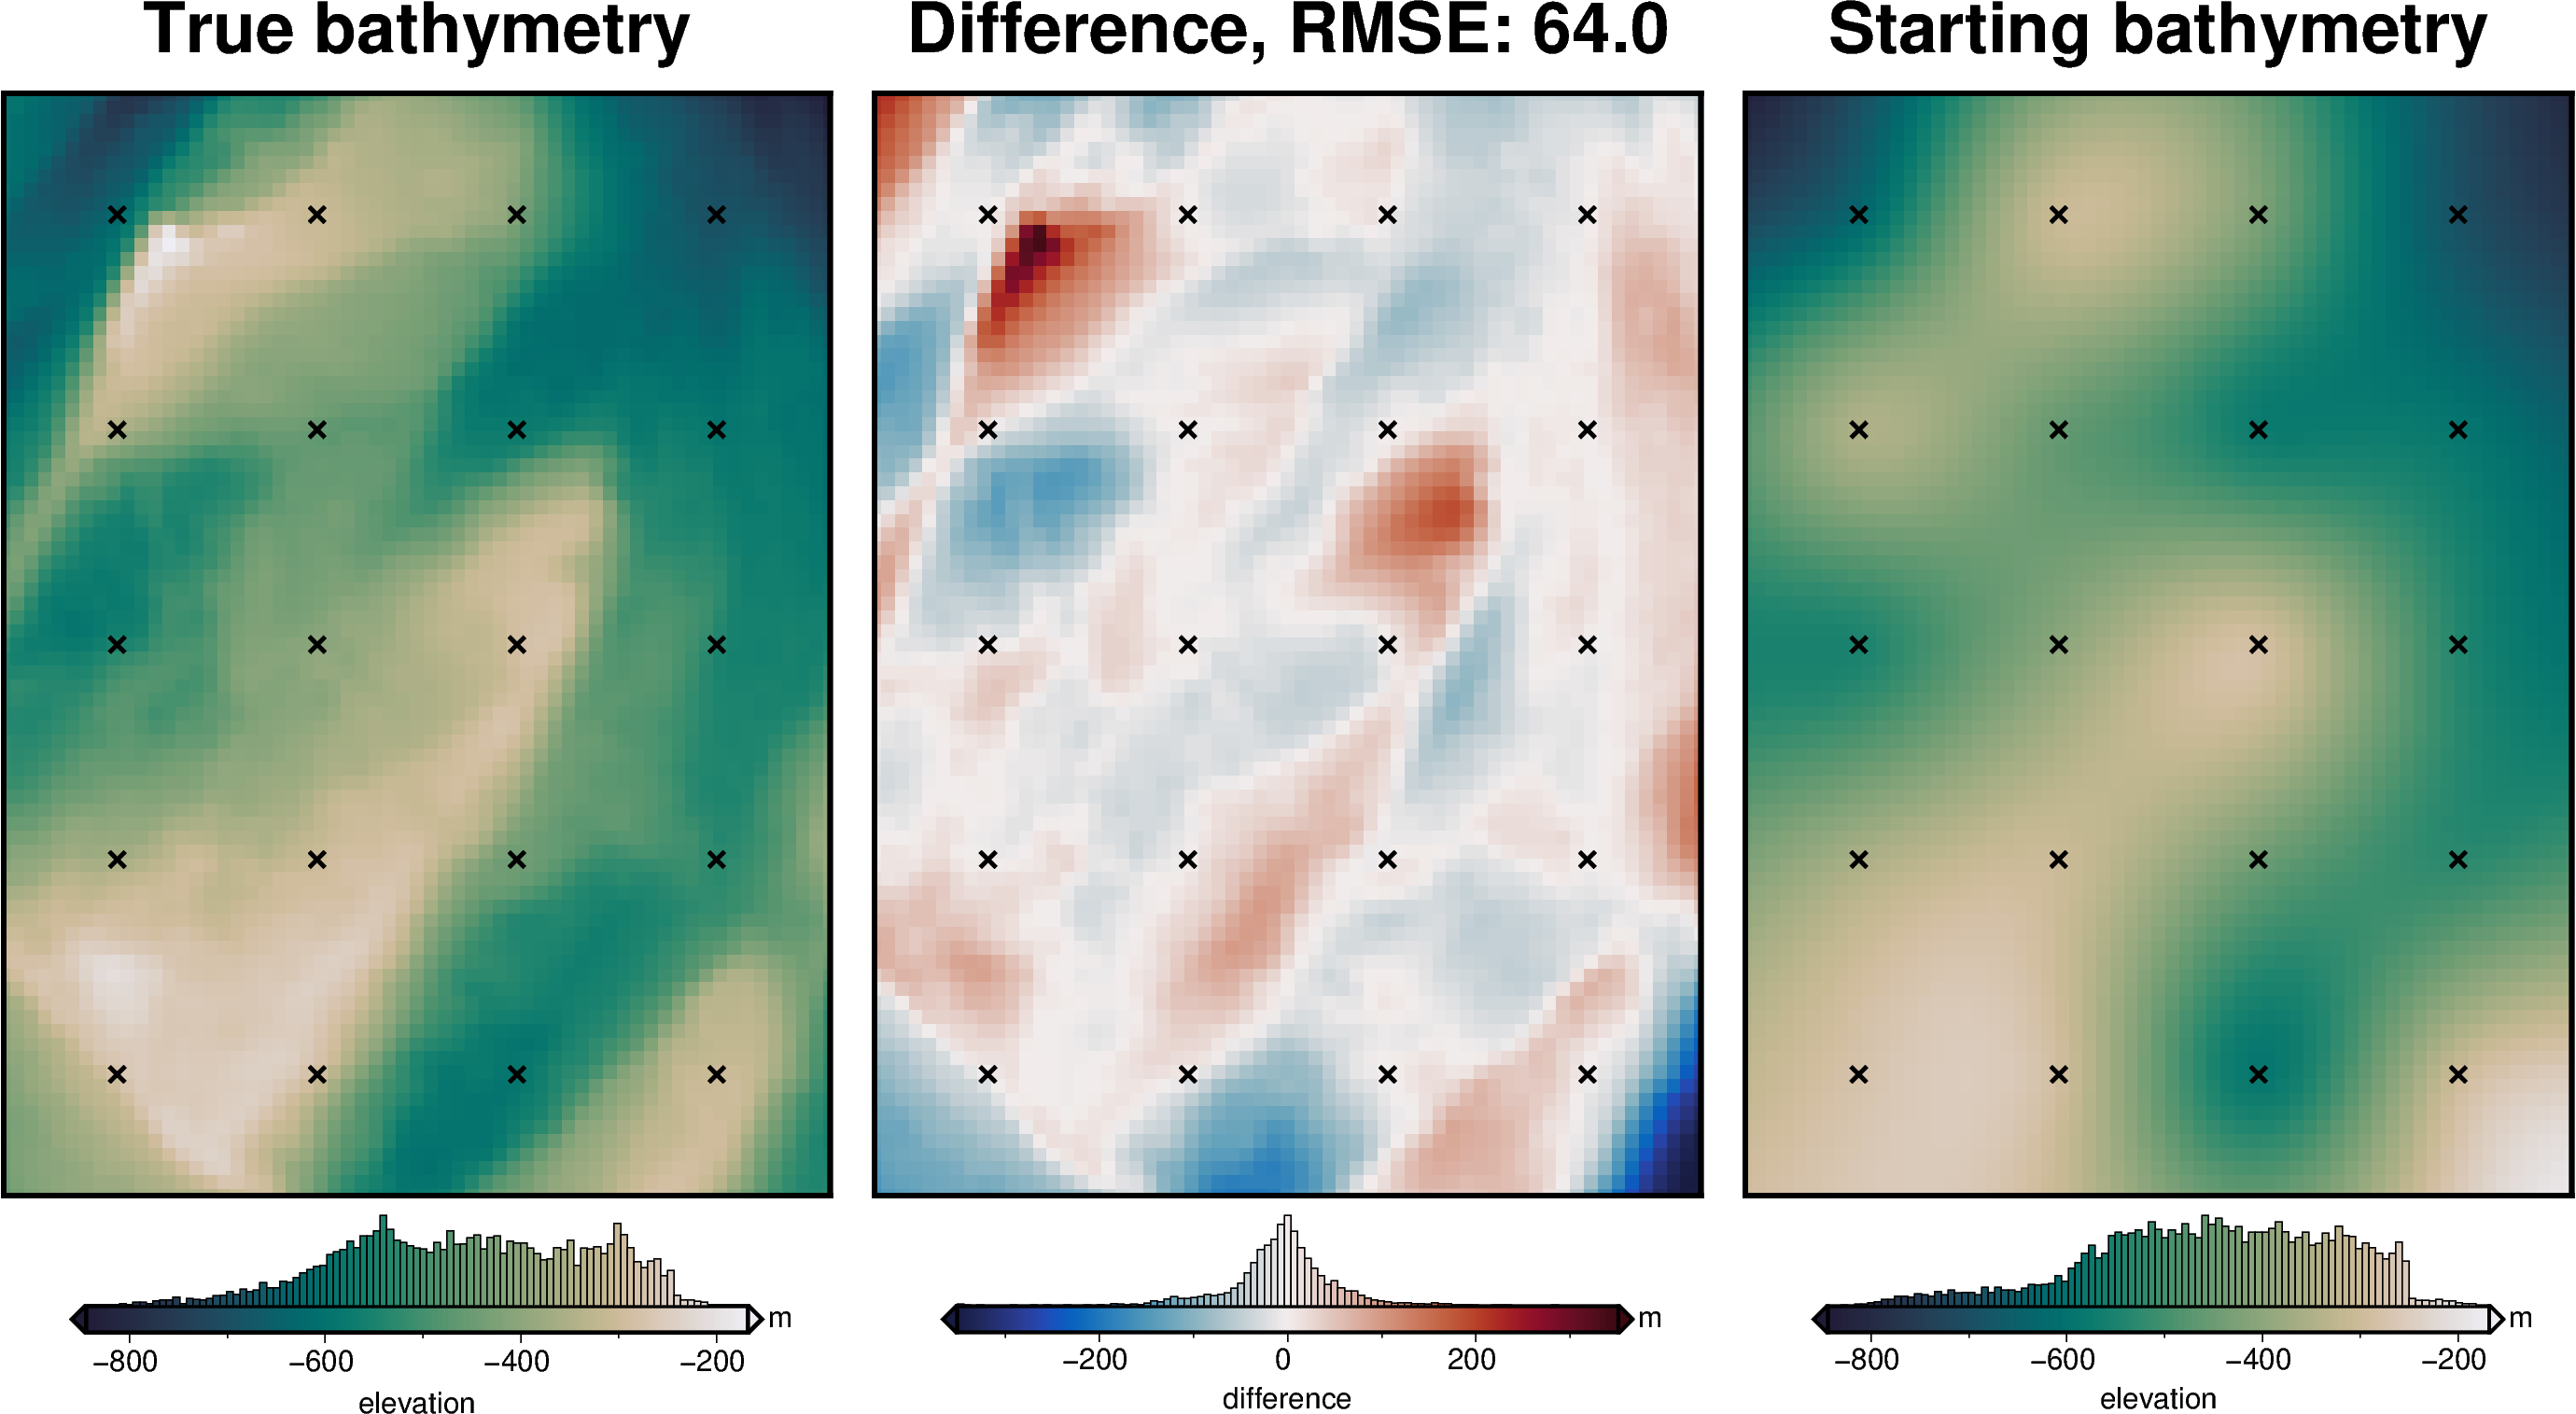

In [10]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [11]:
# the true density contrast is 1476 kg/m3
# density_contrast = 1350
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >=  zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

original_grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        original_grav_df.easting,
        original_grav_df.northing,
        original_grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

original_grav_df

  0%|          | 0/4941 [00:00<?, ?it/s]

,northing,easting,upward,bathymetry_grav,basement_grav_normalized,basement_grav,gravity_anomaly_full_res_no_noise,starting_gravity
0,-1800000.0,-40000.0,1000.0,-28.046289,0.830177,14.275162,-13.771127,-17.821792
1,-1800000.0,-35000.0,1000.0,-26.714502,0.867672,15.212525,-11.501977,-17.569720
2,-1800000.0,-30000.0,1000.0,-25.919276,0.898289,15.977939,-9.941337,-17.324115
3,-1800000.0,-25000.0,1000.0,-25.236960,0.921973,16.570051,-8.666909,-17.088070
4,-1800000.0,-20000.0,1000.0,-24.610928,0.937189,16.950446,-7.660482,-16.863889
...,...,...,...,...,...,...,...,...
4936,-1400000.0,240000.0,1000.0,-48.323584,0.243973,-0.379955,-48.703539,-46.016261
4937,-1400000.0,245000.0,1000.0,-48.356131,0.167427,-2.293598,-50.649729,-46.655929
4938,-1400000.0,250000.0,1000.0,-49.079005,0.076264,-4.572673,-53.651678,-47.247896
4939,-1400000.0,255000.0,1000.0,-49.877171,-0.022265,-7.035902,-56.913073,-47.790857


<!-- # Run ensemble of inversions with varying survey line spacing and noise -->

In [12]:
num = 8 # CHANGE TO 8
log_num = num #+ 1

# Define number of flights lines on log scale
grav_line_numbers = np.unique(np.round(np.geomspace(3,30,num)))
grav_line_numbers = [int(i) for i in grav_line_numbers]
assert len(grav_line_numbers) == num

# Define noise levels for grav data
grav_noise_levels = [float(round(x,2)) for x in np.linspace(0, 6, num)]

print("number of grav lines:", grav_line_numbers)
print("grav noise levels:", grav_noise_levels)

number of grav lines: [3, 4, 6, 8, 11, 16, 22, 30]
grav noise levels: [0.0, 0.86, 1.71, 2.57, 3.43, 4.29, 5.14, 6.0]


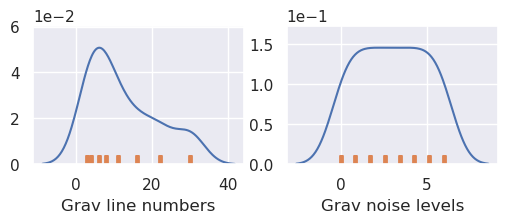

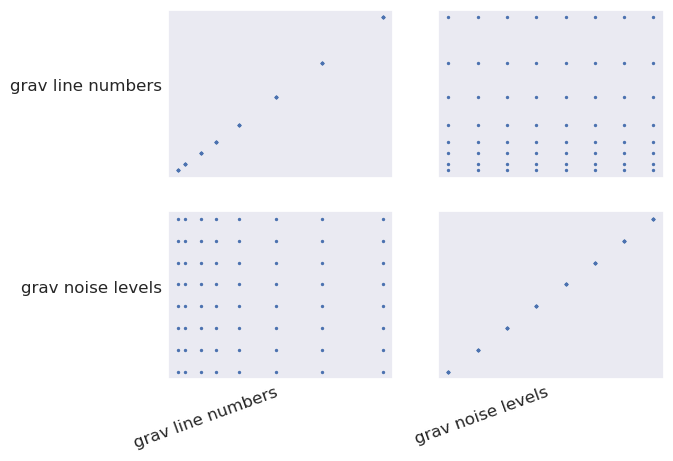

In [13]:
# turn into dataframe
sampled_params_df = pd.DataFrame(
    itertools.product(
        grav_line_numbers,
        grav_noise_levels,
    ),
    columns=[
        "grav_line_numbers",
        "grav_noise_levels",
    ],
)

sampled_params_dict = dict(
    grav_line_numbers=dict(sampled_values=sampled_params_df.grav_line_numbers),
    grav_noise_levels=dict(sampled_values=sampled_params_df.grav_noise_levels),
)

plotting.plot_latin_hypercube(
    sampled_params_dict,
)


<!-- # Create observed gravity
* sample full-res gravity along flight lines
* grid flight line data with equivalent sources

Only need to do this for unique grav_line_numbers  -->

In [14]:
sampled_params_df

,grav_line_numbers,grav_noise_levels
0,3,0.00
1,3,0.86
2,3,1.71
3,3,2.57
4,3,3.43
...,...,...
59,30,2.57
60,30,3.43
61,30,4.29
62,30,5.14


In [ ]:
logging.getLogger().setLevel(logging.WARNING)

sampled_params_df["grav_df_fname"] = pd.Series()
sampled_params_df["grav_survey_df_fname"] = pd.Series()
sampled_params_df["grav_line_spacing"] = pd.Series()
sampled_params_df["grav_eqs_damping"] = pd.Series()
sampled_params_df["grav_eqs_depth"] = pd.Series()
sampled_params_df["grav_eqs_score"] = pd.Series()

grav_grid = original_grav_df.set_index(['northing', 'easting']).to_xarray()

for i, row in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):
    # set file names
    grav_df_fname = f"{ensemble_path}_grav_df_{i}.csv"
    grav_survey_df_fname = f"{ensemble_path}_grav_survey_df_{i}.csv"

    # check if grav_line_numbers is already done
    # if so, copy it
    subset_with_same_params = sampled_params_df[
        (sampled_params_df.grav_line_numbers == row.grav_line_numbers)
    ]

    if (len(subset_with_same_params) > 1) & (subset_with_same_params.grav_df_fname.iloc[0] is not np.nan):
        # copy and rename files
        shutil.copy(subset_with_same_params.grav_df_fname.iloc[0], grav_df_fname)
        shutil.copy(subset_with_same_params.grav_survey_df_fname.iloc[0], grav_survey_df_fname)

        # copy other columns
        sampled_params_df.loc[i, "grav_line_spacing"] = subset_with_same_params.grav_line_spacing.iloc[0]
        sampled_params_df.loc[i, "grav_eqs_damping"] = subset_with_same_params.grav_eqs_damping.iloc[0]
        sampled_params_df.loc[i, "grav_eqs_depth"] = subset_with_same_params.grav_eqs_depth.iloc[0]
        sampled_params_df.loc[i, "grav_eqs_score"] = subset_with_same_params.grav_eqs_score.iloc[0]
        print("skipping and using already create data")
    else:
        # new dataframe
        grav_df = copy.deepcopy(original_grav_df)

        # create flight lines
        grav_survey_df = RIS_synth.airborne_survey(
            along_line_spacing=1e3, ##### CHANGE THIS TO 1e3
            grav_observation_height=1e3,
            NS_line_number=row.grav_line_numbers,
            EW_line_number=row.grav_line_numbers,
            region=inversion_region,
            grav_grid=grav_df.set_index(["northing", "easting"]).to_xarray().gravity_anomaly_full_res_no_noise,
            # plot=True,
        )
        grav_survey_df=grav_survey_df.rename(columns={"gravity_anomaly": "gravity_anomaly_no_noise"})
        x_spacing=(inversion_region[1]-inversion_region[0])/row.grav_line_numbers
        y_spacing=(inversion_region[3]-inversion_region[2])/row.grav_line_numbers
        grav_line_spacing = ((x_spacing + y_spacing)/2)/1e3

        # grid the airborne survey data with equivalent sources
        eqs_study, eqs = optimization.optimize_eq_source_params(
            (grav_survey_df.easting, grav_survey_df.northing, grav_survey_df.upward),
            grav_survey_df.gravity_anomaly_no_noise,
            n_trials=8, ##### CHANGE THIS TO 8
            damping_limits=[1e-20, 1e-2],
            depth_limits=[100, 200e3],
            block_size=spacing*4,
            # plot=True,
            progressbar=False,
            fname=f"../../results/10_eqs.pkl",
        )
        #predict sources onto grid
        grav_df["eqs_gravity_anomaly"] = eqs.predict(
            (
                grav_df.easting,
                grav_df.northing,
                grav_df.upward,
            ),
        )
        grav_df["gravity_anomaly_no_noise"] = grav_df.eqs_gravity_anomaly

        # add to dataframe
        sampled_params_df.loc[i, "grav_line_spacing"] = grav_line_spacing
        sampled_params_df.loc[i, "grav_eqs_damping"] = eqs_study.best_trial.params["damping"]
        sampled_params_df.loc[i, "grav_eqs_depth"] = eqs_study.best_trial.params["depth"]
        sampled_params_df.loc[i, "grav_eqs_score"] = eqs_study.best_trial.value

        # save to files
        grav_survey_df.to_csv(grav_survey_df_fname, index=False)
        grav_df.to_csv(grav_df_fname, index=False)

    # add to dataframe
    sampled_params_df.loc[i, "grav_df_fname"] = grav_df_fname
    sampled_params_df.loc[i, "grav_survey_df_fname"] = grav_survey_df_fname

sampled_params_df.head()

  0%|          | 0/64 [00:00<?, ?it/s]

skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data


skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using already create data
skipping and using alread

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,0.0,43253.784081,0.998785
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,0.0,43253.784081,0.998785
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,0.0,43253.784081,0.998785
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,0.0,43253.784081,0.998785
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,0.0,43253.784081,0.998785


In [16]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [17]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df.head()

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785


<!-- # Add noise to gravity data -->

In [18]:
for i, row in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):
    # load data
    grav_df = pd.read_csv(row.grav_df_fname)

    # contaminated with long-wavelength noise
    contaminated = synthetic.contaminate_with_long_wavelength_noise(
        grav_df.set_index(["northing", "easting"]).to_xarray().gravity_anomaly_no_noise,
        coarsen_factor=None,
        spacing=50e3,
        noise_as_percent=False,
        noise=row.grav_noise_levels,
    )
    contaminated_df = vd.grid_to_table(contaminated.rename("gravity_anomaly_no_noise")).reset_index(drop=True)

    grav_df = pd.merge(
        grav_df.drop(columns=["gravity_anomaly_no_noise"], errors="ignore"),
        contaminated_df,
        on=["easting", "northing"],
    )

    # contaminate gravity with random noise
    grav_df["gravity_anomaly"], stddev = synthetic.contaminate(
        grav_df.gravity_anomaly_no_noise,
        stddev=row.grav_noise_levels,
        percent=False,
        seed=0
    )

    # add noise level to uncert column
    grav_df["uncert"] = row.grav_noise_levels

    # resave gravity dataframe
    grav_df.to_csv(row.grav_df_fname, index=False)

sampled_params_df.head()

  0%|          | 0/64 [00:00<?, ?it/s]

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785


In [19]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [20]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df.head()

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785


In [21]:
# for i, row in sampled_params_df.iterrows():
#     grav_survey_df = pd.read_csv(row.grav_survey_df_fname)
#     grav_df = pd.read_csv(row.grav_df_fname)

#     grav_grid = grav_df.set_index(['northing', 'easting']).to_xarray()

#     # plot the synthetic gravity anomaly grid
#     lims = polar_utils.get_min_max(grav_grid.gravity_anomaly_full_res_no_noise)

#     fig = maps.plot_grd(
#         grav_grid.gravity_anomaly_full_res_no_noise,
#         fig_height=10,
#         cmap="viridis",
#         cpt_lims=lims,
#         title="Full resolution gravity",
#         cbar_label="mGal",
#         cbar_font="18p,Helvetica,black",
#         frame=["nSWe", "xaf10000", "yaf10000"],
#         hist=True,
#         cbar_yoffset=1.5,
#     )
#     # plot observation points
#     fig.plot(
#         grav_survey_df[["easting", "northing"]],
#         style="c.02c",
#         fill="black",
#     )
#     dif = (
#         grav_grid.gravity_anomaly_full_res_no_noise - grav_grid.gravity_anomaly
#     )
#     fig = maps.plot_grd(
#         dif,
#         fig_height=10,
#         cmap="balance+h0",
#         cpt_lims=(-vd.maxabs(dif), vd.maxabs(dif)),
#         title="difference",
#         cbar_label=f"RMSE: {round(utils.rmse(dif),2)} (mGal)",
#         cbar_font="18p,Helvetica,black",
#         hist=True,
#         cbar_yoffset=1.5,
#         grd2_cpt=True,
#         fig=fig,
#         origin_shift="xshift",
#         xshift_amount=1.1,
#     )
#     # plot the synthetic observed gravity grid
#     fig = maps.plot_grd(
#         grav_grid.gravity_anomaly,
#         fig_height=10,
#         cmap="viridis",
#         cpt_lims=lims,
#         title=f"line spacing: {round(row.grav_line_spacing)} km, noise: {round(row.grav_noise_levels,1)} mGal",
#         cbar_label="Sampled and gridded (mGal)",
#         cbar_font="18p,Helvetica,black",
#         frame=["nSwe", "xaf10000", "yaf10000"],
#         hist=True,
#         cbar_yoffset=1.5,
#         fig=fig,
#         origin_shift="xshift",
#         xshift_amount=1.1,
#     )
#     fig.show()

<!-- # Calculate starting gravity and misfit -->

In [22]:
def regional_comparison(df):
    # grid the results
    grav_grid = df.set_index(["northing", "easting"]).to_xarray()

    # compare with true regional
    _ = polar_utils.grd_compare(
        grav_grid.basement_grav,
        grav_grid.reg,
        plot=True,
        grid1_name="True regional misfit",
        grid2_name="Regional misfit",
        hist=True,
        cbar_yoffset=1,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )
    # compare with true residual
    # _ = polar_utils.grd_compare(
    #     grav_grid.true_res,
    #     grav_grid.res,
    #     plot=True,
    #     grid1_name="True residual misfit",
    #     grid2_name="Residual misfit",
    #     cmap="balance+h0",
    #     hist=True,
    #     cbar_yoffset=1,
    #     inset=False,
    #     verbose="q",
    #     title="difference",
    #     grounding_line=False,
    #     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    #     points_style="x.3c",
    # )

In [23]:
logging.getLogger().setLevel(logging.WARNING)

sampled_params_df["reg_eqs_damping"] = pd.Series()
sampled_params_df["reg_eqs_depth"] = pd.Series()
sampled_params_df["reg_eqs_score"] = pd.Series()

# estimate regional
regional_grav_kwargs = dict(
    method="constraints",
    grid_method="eq_sources",
    cv=True,
    cv_kwargs=dict(
        n_trials=50, # CHANGE TO 50
        damping_limits=(1e-30, 10),
        depth_limits=(100, 100e3),
        progressbar=True,
        fname=f"tmp/10_regional_sep",
    ),
    constraints_df=constraint_points,
    # depth="default",
    # damping=None, # CHANGE TO LIMITS
    block_size=None,
)

for i, row in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):
    # load data
    grav_df = pd.read_csv(row.grav_df_fname)

    # calculate the true residual misfit
    grav_df["true_res"] = grav_df.bathymetry_grav - grav_df.starting_gravity

    # temporarily set some kwargs
    temp_reg_kwargs = copy.deepcopy(regional_grav_kwargs)
    temp_reg_kwargs["cv_kwargs"]["fname"] = f"tmp/10_regional_sep_{i}"
    # temp_reg_kwargs["cv_kwargs"]["plot"]=True
    # temp_reg_kwargs["cv_kwargs"]["progressbar"]=True

    grav_df = regional.regional_separation(
        grav_df=grav_df,
        **temp_reg_kwargs,
    )
    # regional_comparison(grav_df)

    # re-load the study from the saved pickle file
    with pathlib.Path(f"tmp/10_regional_sep_{i}.pickle").open("rb") as f:
        reg_study = pickle.load(f)
    reg_eq_damping = min(reg_study.best_trials, key=lambda t: t.values[0]).params["damping"]
    reg_eq_depth = min(reg_study.best_trials, key=lambda t: t.values[0]).params["depth"]
    reg_score = reg_study.best_trial.value

    # add to dataframe
    sampled_params_df.loc[i, "reg_eqs_damping"] = reg_eq_damping
    sampled_params_df.loc[i, "reg_eqs_depth"] = reg_eq_depth
    sampled_params_df.loc[i, "reg_eqs_score"] = reg_score

    # resave gravity dataframe
    grav_df.to_csv(row.grav_df_fname, index=False)

sampled_params_df.head()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score,reg_eqs_damping,reg_eqs_depth,reg_eqs_score
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,0.0,53897.57925,0.115392
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,0.0,27058.887254,0.052498
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,0.0,13261.093576,-0.011647
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,0.0,3679.878815,-0.077591
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,0.000001,100.0,-0.132361


In [24]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [25]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df.head()

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score,reg_eqs_damping,reg_eqs_depth,reg_eqs_score
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,2.963587e-29,53897.579250,0.115392
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.431225e-19,27058.887254,0.052498
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,7.154466e-28,13261.093576,-0.011647
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.103784e-17,3679.878815,-0.077591
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,8.145916e-07,100.000000,-0.132361


<!-- # Damping Cross Validation -->

In [26]:
logging.getLogger().setLevel(logging.WARNING)

sampled_params_df["damping_cv_results_fname"] = pd.Series()

for i, row in tqdm(sampled_params_df.iterrows(), total=len(sampled_params_df)):

    # load data
    grav_df = pd.read_csv(row.grav_df_fname)

    if row.grav_noise_levels == 0:
        l2_norm_tolerance = .3**.5
    else:
        l2_norm_tolerance = row.grav_noise_levels**.5

    # set kwargs to pass to the inversion
    kwargs = {
        # set stopping criteria
        "max_iterations": 200, #### CHANGE THIS TO 200
        "l2_norm_tolerance": l2_norm_tolerance, # square root of the gravity noise
        "delta_l2_norm_tolerance": 1.008,
    }

    # set results file name
    damping_cv_results_fname = f"{ensemble_path}_damping_cv_{i}"

    # run the inversion workflow, including a cross validation for the damping parameter
    _ = inversion.run_inversion_workflow(
        grav_df=grav_df,
        starting_prisms=starting_prisms,
        # for creating test/train splits
        grav_spacing=spacing,
        inversion_region=inversion_region,
        run_damping_cv=True,
        damping_limits=(0.001, 0.1),
        damping_cv_trials=8, ### CHANGE THIS TO 8
        # plot_cv=True,
        fname=damping_cv_results_fname,
        **kwargs,
    )

    # add results file name
    sampled_params_df.loc[i, "damping_cv_results_fname"] = damping_cv_results_fname

sampled_params_df.head()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score,reg_eqs_damping,reg_eqs_depth,reg_eqs_score,damping_cv_results_fname
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,2.963587e-29,53897.579250,0.115392,../../results/10_grav_spacing_vs_noise_ensembl...
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.431225e-19,27058.887254,0.052498,../../results/10_grav_spacing_vs_noise_ensembl...
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,7.154466e-28,13261.093576,-0.011647,../../results/10_grav_spacing_vs_noise_ensembl...
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.103784e-17,3679.878815,-0.077591,../../results/10_grav_spacing_vs_noise_ensembl...
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,8.145916e-07,100.000000,-0.132361,../../results/10_grav_spacing_vs_noise_ensembl...


In [11]:
sampled_params_df["best_damping"] = pd.Series()
sampled_params_df["constraints_damping_cv_rmse"] = pd.Series()
sampled_params_df["inversion_rmse"] = pd.Series()
sampled_params_df["inversion_mae"] = pd.Series()
sampled_params_df["inverted_bathymetry_fname"] = pd.Series()

for i, row in sampled_params_df.iterrows():

    # load saved inversion results
    with pathlib.Path(f"{row.damping_cv_results_fname}_results.pickle").open("rb") as f:
        results = pickle.load(f)

    # load study
    with pathlib.Path(f"{row.damping_cv_results_fname}_damping_cv_study.pickle").open("rb") as f:
        study = pickle.load(f)

    # collect the results
    topo_results, grav_results, parameters, elapsed_time = results
    final_bathymetry = topo_results.set_index(["northing", "easting"]).to_xarray().topo

    # add best damping to dataframe
    sampled_params_df.loc[i, "best_damping"] = parameters.get("Solver damping")

    # if row.grav_line_spacing==175:
    # if row.grav_noise_levels==0:
    # plotting.plot_convergence(
    #     grav_results,
    #     params=parameters,
    # )

    # plotting.plot_cv_scores(
    #         study.trials_dataframe().value.values,
    #         study.trials_dataframe().params_damping.values,
    #         param_name="Damping",
    #         logx=True,
    #         logy=True,
    #     )

    # plotting.plot_inversion_results(
    #     grav_results,
    #     topo_results,
    #     parameters,
    #     inversion_region,
    #     iters_to_plot=2,
    #     # plot_iter_results=False,
    #     plot_topo_results=False,
    #     plot_grav_results=False,
    # )

    # _ = polar_utils.grd_compare(
    #     bathymetry,
    #     final_bathymetry,
    #     region=inversion_region,
    #     plot=True,
    #     grid1_name="True topography",
    #     grid2_name="Inverted topography",
    #     robust=True,
    #     hist=True,
    #     inset=False,
    #     verbose="q",
    #     title="difference",
    #     grounding_line=False,
    #     reverse_cpt=True,
    #     cmap="rain",
    #     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    #     points_style="x.2c",
    # )

    # sample the inverted topography at the constraint points
    constraint_points = utils.sample_grids(
        constraint_points,
        final_bathymetry,
        "inverted_damping_cv_bathymetry",
        coord_names=("easting", "northing"),
    )
    constraints_rmse = utils.rmse(constraint_points.true_upward - constraint_points.inverted_damping_cv_bathymetry)

    bathymetry_inner = bathymetry.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )
    final_bathymetry_inner = final_bathymetry.sel(
        easting=slice(inversion_region[0], inversion_region[1]),
        northing=slice(inversion_region[2], inversion_region[3]),
    )
    inversion_rmse = utils.rmse(bathymetry_inner - final_bathymetry_inner)
    inversion_mae = float(np.mean(np.abs(bathymetry_inner - final_bathymetry_inner)))

    # save final topography to file
    inverted_bathymetry_fname = f"{ensemble_path}_inverted_damping_cv_bathymetry_{i}.nc"
    final_bathymetry.to_netcdf(inverted_bathymetry_fname)

    # add to dataframe
    sampled_params_df.loc[i, "inverted_bathymetry_fname"] = inverted_bathymetry_fname
    sampled_params_df.loc[i, "constraints_damping_cv_rmse"] = constraints_rmse
    sampled_params_df.loc[i, "inversion_rmse"] = inversion_rmse
    sampled_params_df.loc[i, "inversion_mae"] = inversion_mae

sampled_params_df.head()

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score,reg_eqs_damping,reg_eqs_depth,reg_eqs_score,damping_cv_results_fname,best_damping,constraints_damping_cv_rmse,inversion_rmse,inverted_bathymetry_fname,regional_error,regional_rms,topo_improvement,inversion_mae
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,2.963587e-29,53897.579250,0.115392,../../results/10_grav_spacing_vs_noise_ensembl...,0.026273,3.48332,73.902818,../../results/10_grav_spacing_vs_noise_ensembl...,5.981771,9.849210,33.882345,53.969786
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.431225e-19,27058.887254,0.052498,../../results/10_grav_spacing_vs_noise_ensembl...,0.024578,8.742092,87.842162,../../results/10_grav_spacing_vs_noise_ensembl...,6.787185,7.952930,19.943001,64.178698
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,7.154466e-28,13261.093576,-0.011647,../../results/10_grav_spacing_vs_noise_ensembl...,0.024578,19.518193,120.029779,../../results/10_grav_spacing_vs_noise_ensembl...,8.360054,5.542543,-12.244616,92.133398
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.103784e-17,3679.878815,-0.077591,../../results/10_grav_spacing_vs_noise_ensembl...,0.024578,29.884009,167.280625,../../results/10_grav_spacing_vs_noise_ensembl...,10.781784,2.222820,-59.495463,134.278267
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,8.145916e-07,100.000000,-0.132361,../../results/10_grav_spacing_vs_noise_ensembl...,0.024578,176.208454,199.262911,../../results/10_grav_spacing_vs_noise_ensembl...,12.247819,0.077872,-91.477748,162.543545


In [28]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [10]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df.head()

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score,reg_eqs_damping,reg_eqs_depth,reg_eqs_score,damping_cv_results_fname,best_damping,constraints_damping_cv_rmse,inversion_rmse,inverted_bathymetry_fname,regional_error,regional_rms,topo_improvement
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,2.963587e-29,53897.579250,0.115392,../../results/10_grav_spacing_vs_noise_ensembl...,0.026273,3.483320,73.902818,../../results/10_grav_spacing_vs_noise_ensembl...,5.981771,9.849210,33.882345
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.431225e-19,27058.887254,0.052498,../../results/10_grav_spacing_vs_noise_ensembl...,0.024578,8.742092,87.842162,../../results/10_grav_spacing_vs_noise_ensembl...,6.787185,7.952930,19.943001
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,7.154466e-28,13261.093576,-0.011647,../../results/10_grav_spacing_vs_noise_ensembl...,0.024578,19.518193,120.029779,../../results/10_grav_spacing_vs_noise_ensembl...,8.360054,5.542543,-12.244616
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.103784e-17,3679.878815,-0.077591,../../results/10_grav_spacing_vs_noise_ensembl...,0.024578,29.884009,167.280625,../../results/10_grav_spacing_vs_noise_ensembl...,10.781784,2.222820,-59.495463
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,8.145916e-07,100.000000,-0.132361,../../results/10_grav_spacing_vs_noise_ensembl...,0.024578,176.208454,199.262911,../../results/10_grav_spacing_vs_noise_ensembl...,12.247819,0.077872,-91.477748


<!-- ## Density CV -->

In [12]:
sampled_params_df["regional_error"] = pd.Series()
sampled_params_df["regional_rms"] = pd.Series()

for i, row in sampled_params_df.iterrows():
    grav_df = pd.read_csv(row.grav_df_fname)

    sampled_params_df.loc[i, "regional_error"] = utils.rmse(grav_df.basement_grav - grav_df.reg)
    sampled_params_df.loc[i, "regional_rms"] = utils.rmse(grav_df.basement_grav)

starting_bathymetry_rmse = utils.rmse(bathymetry - starting_bathymetry)
starting_bathymetry_mae = float(np.mean(np.abs(bathymetry - starting_bathymetry)))

sampled_params_df["topo_improvement_rmse"] = starting_bathymetry_rmse - sampled_params_df.inversion_rmse
sampled_params_df["topo_improvement_mae"] = starting_bathymetry_mae - sampled_params_df.inversion_mae

sampled_params_df#.head()

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score,reg_eqs_damping,reg_eqs_depth,...,best_damping,constraints_damping_cv_rmse,inversion_rmse,inverted_bathymetry_fname,regional_error,regional_rms,topo_improvement,inversion_mae,topo_improvement_rmse,topo_improvement_mae
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,2.963587e-29,53897.579250,...,0.026273,3.48332,73.902818,../../results/10_grav_spacing_vs_noise_ensembl...,5.981771,12.295276,33.882345,53.969786,33.882345,15.900971
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.431225e-19,27058.887254,...,0.024578,8.742092,87.842162,../../results/10_grav_spacing_vs_noise_ensembl...,6.787185,12.295276,19.943001,64.178698,19.943001,5.692059
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,7.154466e-28,13261.093576,...,0.024578,19.518193,120.029779,../../results/10_grav_spacing_vs_noise_ensembl...,8.360054,12.295276,-12.244616,92.133398,-12.244616,-22.262642
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.103784e-17,3679.878815,...,0.024578,29.884009,167.280625,../../results/10_grav_spacing_vs_noise_ensembl...,10.781784,12.295276,-59.495463,134.278267,-59.495463,-64.40751
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,8.145916e-07,100.000000,...,0.024578,176.208454,199.262911,../../results/10_grav_spacing_vs_noise_ensembl...,12.247819,12.295276,-91.477748,162.543545,-91.477748,-92.672788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,30,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,11.666667,1.437394e-20,111868.144128,0.998889,9.495784e+00,99311.146710,...,0.024578,139.979879,155.200385,../../results/10_grav_spacing_vs_noise_ensembl...,8.397728,12.295276,-47.415223,122.027701,-47.415223,-52.156944
60,30,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,11.666667,1.437394e-20,111868.144128,0.998889,9.450277e+00,98180.052174,...,0.023168,146.341818,166.6227,../../results/10_grav_spacing_vs_noise_ensembl...,8.477468,12.295276,-58.837538,131.296807,-58.837538,-61.42605
61,30,4.29,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,11.666667,1.437394e-20,111868.144128,0.998889,1.000000e+01,74905.507866,...,0.022335,148.334936,177.088352,../../results/10_grav_spacing_vs_noise_ensembl...,8.227988,12.295276,-69.303189,140.343179,-69.303189,-70.472423
62,30,5.14,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,11.666667,1.437394e-20,111868.144128,0.998889,1.000000e+01,74905.507866,...,0.021901,160.149921,195.11767,../../results/10_grav_spacing_vs_noise_ensembl...,8.368038,12.295276,-87.332508,155.229572,-87.332508,-85.358815


In [13]:
sampled_params_df.to_csv(ensemble_fname, index=False)

In [14]:
ensemble_fname[0:-4]

'../../results/10_grav_spacing_vs_noise_ensemble_strong_regional'

In [49]:
# sampled_params_df.to_csv(f"{ensemble_fname[0:-4]}_backup.csv", index=False)

In [15]:
sampled_params_df = pd.read_csv(ensemble_fname)
sampled_params_df

,grav_line_numbers,grav_noise_levels,grav_df_fname,grav_survey_df_fname,grav_line_spacing,grav_eqs_damping,grav_eqs_depth,grav_eqs_score,reg_eqs_damping,reg_eqs_depth,...,best_damping,constraints_damping_cv_rmse,inversion_rmse,inverted_bathymetry_fname,regional_error,regional_rms,topo_improvement,inversion_mae,topo_improvement_rmse,topo_improvement_mae
0,3,0.00,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,2.963587e-29,53897.579250,...,0.026273,3.483320,73.902818,../../results/10_grav_spacing_vs_noise_ensembl...,5.981771,12.295276,33.882345,53.969786,33.882345,15.900971
1,3,0.86,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.431225e-19,27058.887254,...,0.024578,8.742092,87.842162,../../results/10_grav_spacing_vs_noise_ensembl...,6.787185,12.295276,19.943001,64.178698,19.943001,5.692059
2,3,1.71,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,7.154466e-28,13261.093576,...,0.024578,19.518193,120.029779,../../results/10_grav_spacing_vs_noise_ensembl...,8.360054,12.295276,-12.244616,92.133398,-12.244616,-22.262642
3,3,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,1.103784e-17,3679.878815,...,0.024578,29.884009,167.280625,../../results/10_grav_spacing_vs_noise_ensembl...,10.781784,12.295276,-59.495463,134.278267,-59.495463,-64.407510
4,3,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,116.666667,3.385434e-14,43253.784081,0.998785,8.145916e-07,100.000000,...,0.024578,176.208454,199.262911,../../results/10_grav_spacing_vs_noise_ensembl...,12.247819,12.295276,-91.477748,162.543545,-91.477748,-92.672788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,30,2.57,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,11.666667,1.437394e-20,111868.144128,0.998889,9.495784e+00,99311.146710,...,0.024578,139.979879,155.200385,../../results/10_grav_spacing_vs_noise_ensembl...,8.397728,12.295276,-47.415223,122.027701,-47.415223,-52.156944
60,30,3.43,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,11.666667,1.437394e-20,111868.144128,0.998889,9.450277e+00,98180.052174,...,0.023168,146.341818,166.622700,../../results/10_grav_spacing_vs_noise_ensembl...,8.477468,12.295276,-58.837538,131.296807,-58.837538,-61.426050
61,30,4.29,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,11.666667,1.437394e-20,111868.144128,0.998889,1.000000e+01,74905.507866,...,0.022335,148.334936,177.088352,../../results/10_grav_spacing_vs_noise_ensembl...,8.227988,12.295276,-69.303189,140.343179,-69.303189,-70.472423
62,30,5.14,../../results/10_grav_spacing_vs_noise_ensembl...,../../results/10_grav_spacing_vs_noise_ensembl...,11.666667,1.437394e-20,111868.144128,0.998889,1.000000e+01,74905.507866,...,0.021901,160.149921,195.117670,../../results/10_grav_spacing_vs_noise_ensembl...,8.368038,12.295276,-87.332508,155.229572,-87.332508,-85.358815


In [16]:
polar_utils.get_min_max(sampled_params_df.inversion_rmse, robust=True)

(np.float64(83.12121945169734), np.float64(221.87635186175655))

In [17]:
polar_utils.get_min_max(sampled_params_df.inversion_rmse, robust=False)

(np.float64(73.90281787930157), np.float64(240.0610028765977))

In [32]:
inversion_rmse_lims = polar_utils.get_min_max(sampled_params_df.inversion_rmse, robust=True)
inversion_rmse_lims

(np.float64(83.12121945169734), np.float64(221.87635186175655))

In [36]:
line_plot_inversion_rmse_lims = (13, 240)

In [42]:
starting_bathymetry_mae

69.87075685126707

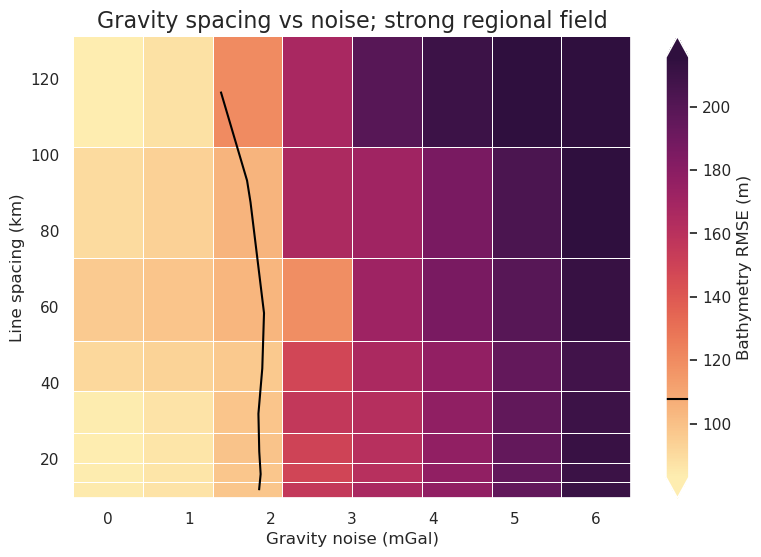

In [41]:
fig = RIS_plotting.plot_2var_ensemble(
    sampled_params_df,
    x="grav_noise_levels",
    y="grav_line_spacing",
    x_title="Gravity noise (mGal)",
    y_title="Line spacing (km)",

    background="inversion_rmse",
    background_title="Bathymetry RMSE (m)",
    # background="regional_error",
    # background_title="Regional gravity RMSE (mGal)",

    # background_robust=True,
    background_cpt_lims=[inversion_rmse_lims[0],starting_bathymetry_rmse*2],
    plot_contours=[starting_bathymetry_rmse],
    plot_title="Gravity spacing vs noise; strong regional field",
)
# Results
# expected relationship between noise, line spacing and performance
# inversion only offers improvement for noise < 2mGal if strong regional


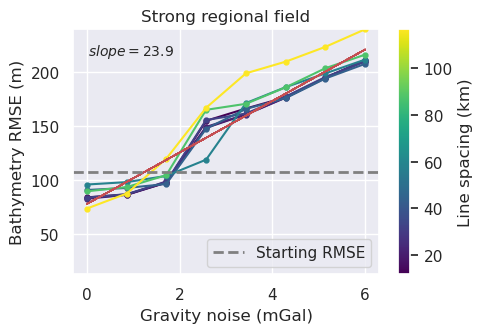

In [37]:
RIS_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    y="inversion_rmse",
    x="grav_noise_levels",
    groupby_col="grav_line_spacing",
    x_label="Gravity noise (mGal)",
    cbar_label="Line spacing (km)",
    trend_line=True,
    horizontal_line=starting_bathymetry_rmse,
    horizontal_line_label="Starting RMSE",
    horizontal_line_label_loc="lower right",
    plot_title="Strong regional field",
    y_lims=line_plot_inversion_rmse_lims,
)
# Results
# linear relationship between noise and performance for all line spacings
# at high noise levels, lines spacing doesn't matter

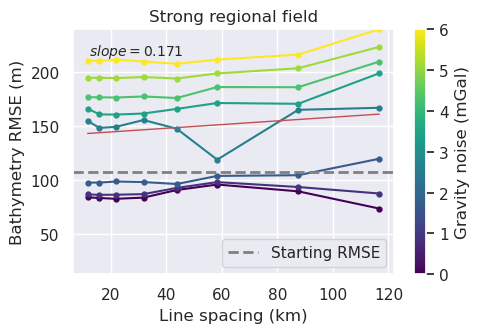

In [38]:
RIS_plotting.plot_ensemble_as_lines(
    sampled_params_df,
    y="inversion_rmse",
    x="grav_line_spacing",
    groupby_col="grav_noise_levels",
    x_label="Line spacing (km)",
    cbar_label="Gravity noise (mGal)",
    trend_line=True,
    horizontal_line=starting_bathymetry_rmse,
    horizontal_line_label="Starting RMSE",
    horizontal_line_label_loc="lower right",
    plot_title="Strong regional field",
    y_lims=line_plot_inversion_rmse_lims,
)
# Results
# linear relationship between line spacing and performance for all noise levels
# even at low line spacings, noise still matters
# noise is slightly more important at smaller line spacings

# Noise is more important than line spacing!!